<a href="https://colab.research.google.com/github/morningB/shooting_game/blob/master/realproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택

Saving eyes.zip to eyes.zip


In [2]:
!unzip eyes.zip -d eyes/    #eyes 폴더 만들어 압축 풀기

Archive:  eyes.zip
   creating: eyes/test/Eyeclose/
  inflating: eyes/test/Eyeclose/0.jpg  
  inflating: eyes/test/Eyeclose/1.jpg  
  inflating: eyes/test/Eyeclose/10.jpg  
  inflating: eyes/test/Eyeclose/11.jpg  
  inflating: eyes/test/Eyeclose/12.jpg  
  inflating: eyes/test/Eyeclose/13.jpg  
  inflating: eyes/test/Eyeclose/14.jpg  
  inflating: eyes/test/Eyeclose/15.jpg  
  inflating: eyes/test/Eyeclose/16.jpg  
  inflating: eyes/test/Eyeclose/17.jpg  
  inflating: eyes/test/Eyeclose/18.jpg  
  inflating: eyes/test/Eyeclose/19.jpg  
  inflating: eyes/test/Eyeclose/2.jpg  
  inflating: eyes/test/Eyeclose/20.jpg  
  inflating: eyes/test/Eyeclose/21.jpg  
  inflating: eyes/test/Eyeclose/22.jpg  
  inflating: eyes/test/Eyeclose/23.jpg  
  inflating: eyes/test/Eyeclose/24.jpg  
  inflating: eyes/test/Eyeclose/25.jpg  
  inflating: eyes/test/Eyeclose/26.jpg  
  inflating: eyes/test/Eyeclose/27.jpg  
  inflating: eyes/test/Eyeclose/28.jpg  
  inflating: eyes/test/Eyeclose/29.jpg  
  inflat

In [3]:
data_path = 'eyes/train/' # train 데이터 셋
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

569


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
test_path = 'eyes/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(test_dataset))

108


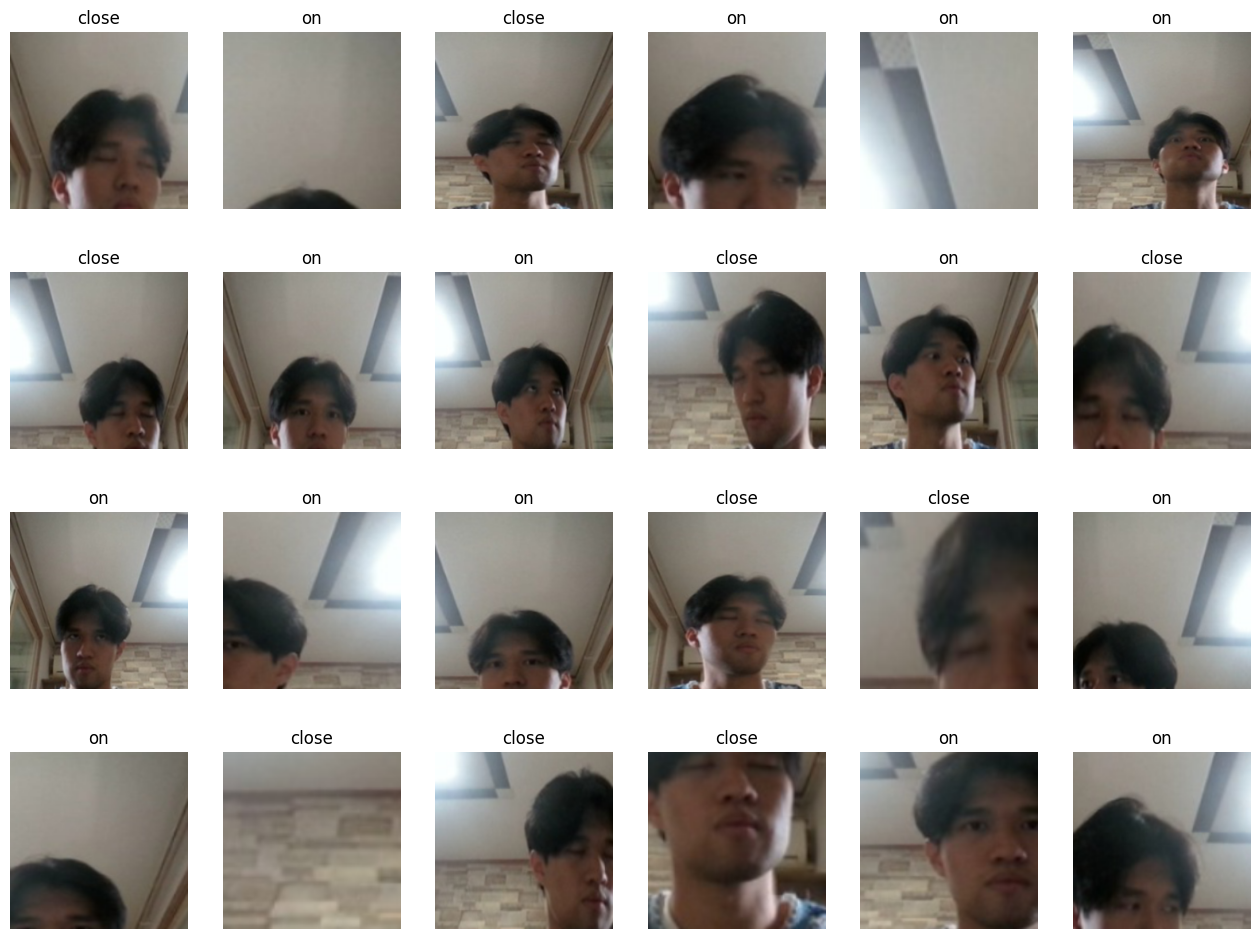

In [5]:
samples, labels = next(iter(train_loader))
classes = {0:'close',1:'on'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [6]:
class EyesCNN(nn.Module):    
    def __init__(self):
        super(EyesCNN, self).__init__()        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding=1),  #224 -7 +2 /1 +1      220
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32 * 220 -2 /2 +1  110
        )       
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5), # 42 * 110-5 /1 +1 = 106
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 106-2/2+1 64* 53 
        )     
        # 64*53 
#        self.layer3 = nn.Sequential(
#           nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3,padding=2), #64* 53-3 +4 /1 +1 =55          
#           nn.BatchNorm2d(64),
#           nn.ReLU(),
#           nn.MaxPool2d(kernel_size=3,stride=2) #55-3 /2 +1  27
#        )
#        self.layer4 = nn.Sequential(
#           nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1,padding=2), #64* 27-1+4/1 +1 31
#            nn.BatchNorm2d(64),
#            nn.ReLU(),
#            nn.MaxPool2d(kernel_size=3,stride=4) #64* 31 - 3/4 +1
#        )
       

        self.fc1 = nn.Linear(in_features=64*53*53, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
#        out = self.layer3(out)
#        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)       
        return out

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.001;
model = EyesCNN();
model.to(device)


criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

EyesCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=179776, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=2, bias=True)
)


In [8]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=20, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('eyes/', '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))    
    return acc_history, loss_history

In [9]:
train_acc_hist, train_loss_hist = train_model(model, train_loader, criterion, optimizer, device)

Epoch 0/82
----------


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Loss: 39.0874 Acc: 0.5149

Epoch 1/82
----------
Loss: 9.6495 Acc: 0.5062

Epoch 2/82
----------
Loss: 4.1373 Acc: 0.4763

Epoch 3/82
----------
Loss: 1.4753 Acc: 0.5448

Epoch 4/82
----------
Loss: 1.2081 Acc: 0.5343

Epoch 5/82
----------
Loss: 0.8556 Acc: 0.5677

Epoch 6/82
----------
Loss: 0.8778 Acc: 0.5536

Epoch 7/82
----------
Loss: 0.9813 Acc: 0.5132

Epoch 8/82
----------
Loss: 0.9417 Acc: 0.5659

Epoch 9/82
----------
Loss: 0.8642 Acc: 0.5343

Epoch 10/82
----------
Loss: 0.8255 Acc: 0.5677

Epoch 11/82
----------
Loss: 0.9334 Acc: 0.5360

Epoch 12/82
----------
Loss: 0.8891 Acc: 0.5518

Epoch 13/82
----------
Loss: 0.9261 Acc: 0.5571

Epoch 14/82
----------
Loss: 0.8743 Acc: 0.5888

Epoch 15/82
----------
Loss: 0.9842 Acc: 0.5554

Epoch 16/82
----------
Loss: 1.0978 Acc: 0.5237

Epoch 17/82
----------
Loss: 0.8898 Acc: 0.5571

Epoch 18/82
----------
Loss: 1.0896 Acc: 0.5466

Epoch 19/82
----------
Loss: 0.9506 Acc: 0.5431

Epoch 20/82
----------
Loss: 0.9535 Acc: 0.5571

Ep

In [10]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('eyes/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)           
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
            
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history



In [11]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['eyes/00.pth', 'eyes/01.pth', 'eyes/02.pth', 'eyes/03.pth', 'eyes/04.pth', 'eyes/05.pth', 'eyes/06.pth', 'eyes/07.pth', 'eyes/08.pth', 'eyes/09.pth', 'eyes/10.pth', 'eyes/11.pth', 'eyes/12.pth', 'eyes/13.pth', 'eyes/14.pth', 'eyes/15.pth', 'eyes/16.pth', 'eyes/17.pth', 'eyes/18.pth', 'eyes/19.pth', 'eyes/20.pth', 'eyes/21.pth', 'eyes/22.pth', 'eyes/23.pth', 'eyes/24.pth', 'eyes/25.pth', 'eyes/26.pth', 'eyes/27.pth', 'eyes/28.pth', 'eyes/29.pth', 'eyes/30.pth', 'eyes/31.pth', 'eyes/32.pth', 'eyes/33.pth', 'eyes/34.pth', 'eyes/35.pth', 'eyes/36.pth', 'eyes/37.pth', 'eyes/38.pth', 'eyes/39.pth', 'eyes/40.pth', 'eyes/41.pth', 'eyes/42.pth', 'eyes/43.pth', 'eyes/44.pth', 'eyes/45.pth', 'eyes/46.pth', 'eyes/47.pth', 'eyes/48.pth', 'eyes/49.pth', 'eyes/50.pth', 'eyes/51.pth', 'eyes/52.pth', 'eyes/53.pth', 'eyes/54.pth', 'eyes/55.pth', 'eyes/56.pth', 'eyes/57.pth', 'eyes/58.pth', 'eyes/59.pth', 'eyes/60.pth', 'eyes/61.pth', 'eyes/62.pth', 'eyes/63.pth', 'eyes/64.pth', 'eyes/65.pth

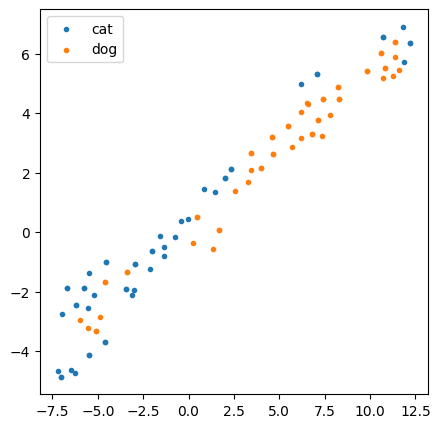

In [12]:
# CNN TSNE
actual = []
deep_features = []

model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = model(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['cat', 'dog']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()

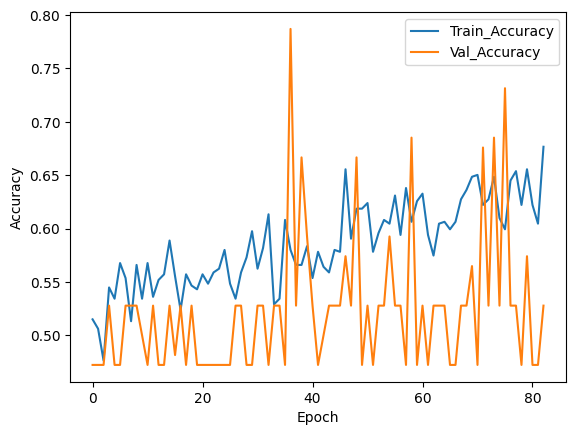

In [13]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train_Accuracy', 'Val_Accuracy'])
plt.show()

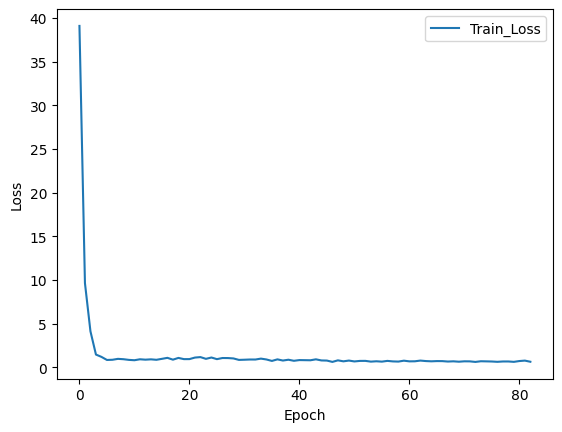

In [14]:
plt.plot(train_loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train_Loss'])
plt.show()